<a href="https://colab.research.google.com/github/Asaf95/Apple-stock-price-prediction/blob/Einav/Apple_Stock_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [ ]:
# pip install alpha_vantage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tsml_m3
import get_data
import data_preparation
import lstm_model
import test_col01
import data_pre

# Main

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Data-Mi/Project_2/DATA/AAPL_rawdata.csv")
#df = pd.read_csv(data, encoding = "ISO-8859-1")
df = pd.DataFrame(df)
df_newL = df.copy()
df

,date,1. open,2. high,3. low,4. close,5. volume
0,2022-03-28,172.17,175.73,172.00,175.60,90371916.0
1,2022-03-25,173.88,175.28,172.75,174.72,80281664.0
2,2022-03-24,171.06,174.14,170.21,174.07,90131418.0
3,2022-03-23,167.99,172.64,167.65,170.21,98062674.0
4,2022-03-22,165.51,169.42,164.91,168.82,80979755.0
...,...,...,...,...,...,...
5633,1999-11-05,84.62,88.37,84.00,88.31,3721500.0
5634,1999-11-04,82.06,85.37,80.62,83.62,3384700.0
5635,1999-11-03,81.62,83.25,81.00,81.50,2932700.0
5636,1999-11-02,78.00,81.69,77.31,80.25,3564600.0


In [ ]:
clean_df = data_pre.basic_prepare(df)
df = clean_df.rename(columns={'open': 'Open', 'high':'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume','date':'Date'})
df

,Date,Open,High,Low,Close,Volume
0,2022-03-28,172.170000,175.730000,172.000000,175.600000,90371916.0
1,2022-03-25,173.880000,175.280000,172.750000,174.720000,80281664.0
2,2022-03-24,171.060000,174.140000,170.210000,174.070000,90131418.0
3,2022-03-23,167.990000,172.640000,167.650000,170.210000,98062674.0
4,2022-03-22,165.510000,169.420000,164.910000,168.820000,80979755.0
...,...,...,...,...,...,...
5633,1999-11-05,0.755536,0.789018,0.750000,0.788482,416808000.0
5634,1999-11-04,0.732679,0.762232,0.719821,0.746607,379086400.0
5635,1999-11-03,0.728750,0.743304,0.723214,0.727679,328462400.0
5636,1999-11-02,0.696429,0.729375,0.690268,0.716518,399235200.0


LSTM Model

In [ ]:
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
    
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
      df_subset = dataframe.loc[:target_date].tail(n+1)
      
      if len(df_subset) != n+1:
        print(f'Error: Window of size {n} is too large for date {target_date}')
        return

In [ ]:
def New_LSTM(df, start_time, end_time):
  df_newL = df
  df_newL = df_newL[['Date', 'Close']]
  df_newL['Date']
  import datetime

  datetime_object = str_to_datetime('1986-03-19')
  datetime_object
  df_newL['Date'] = df_newL['Date'].apply(str_to_datetime)
  df_newL['Date']
  df_newL.index = df_newL.pop('Date')
  df_newL

  import matplotlib.pyplot as plt

  plt.plot(df_newL.index, df_newL['Close'])
  import numpy as np

  def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
      df_subset = dataframe.loc[:target_date].tail(n+1)
      
      if len(df_subset) != n+1:
        print(f'Error: Window of size {n} is too large for date {target_date}')
        return

      values = df_subset['Close'].to_numpy()
      x, y = values[:-1], values[-1]

      dates.append(target_date)
      X.append(x)
      Y.append(y)

      next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
      next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
      next_date_str = next_datetime_str.split('T')[0]
      year_month_day = next_date_str.split('-')
      year, month, day = year_month_day
      next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
      
      if last_time:
        break
      
      target_date = next_date

      if target_date == last_date:
        last_time = True
      
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
      X[:, i]
      ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df

  # Start day second time around: '2021-03-25'
  windowed_df = df_to_windowed_df(df_newL, 
                                  start_time, 
                                  end_time,
                                  n=3)
  print(windowed_df)

  def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

  dates, X, y = windowed_df_to_date_X_y(windowed_df)

  dates.shape, X.shape, y.shape

  q_80 = int(len(dates) * .8)
  q_90 = int(len(dates) * .9)

  dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

  dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
  dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

  plt.plot(dates_train, y_train)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, y_test)

  plt.legend(['Train', 'Validation', 'Test'])
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras import layers

  model = Sequential([layers.Input((3, 1)),
                      layers.LSTM(64),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(32, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse', 
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
  train_predictions = model.predict(X_train).flatten()

  # Showing the results of the model 

  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.legend(['Training Predictions', 'Training Observations'])

  val_predictions = model.predict(X_val).flatten()

  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.legend(['Validation Predictions', 'Validation Observations'])

  test_predictions = model.predict(X_test).flatten()

  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)
  plt.legend(['Testing Predictions', 'Testing Observations'])
  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)
  plt.legend(['Training Predictions', 
              'Training Observations',
              'Validation Predictions', 
              'Validation Observations',
              'Testing Predictions', 
              'Testing Observations'])
  
  from copy import deepcopy

  recursive_predictions = []
  recursive_dates = np.concatenate([dates_val, dates_test])

  for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

  plt.plot(dates_train, train_predictions)
  plt.plot(dates_train, y_train)
  plt.plot(dates_val, val_predictions)
  plt.plot(dates_val, y_val)
  plt.plot(dates_test, test_predictions)
  plt.plot(dates_test, y_test)
  plt.plot(recursive_dates, recursive_predictions)
  plt.legend(['Training Predictions', 
              'Training Observations',
              'Validation Predictions', 
              'Validation Observations',
              'Testing Predictions', 
              'Testing Observations',
              'Recursive Predictions'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


    Target Date  Target-3  Target-2  Target-1  Target
0    2021-03-25    123.39    122.54    120.09  120.59
1    2021-03-26    122.54    120.09    120.59  121.21
2    2021-03-29    120.09    120.59    121.21  121.39
3    2021-03-30    120.59    121.21    121.39  119.90
4    2021-03-31    121.21    121.39    119.90  122.15
..          ...       ...       ...       ...     ...
245  2022-03-15    158.52    154.73    150.62  155.09
246  2022-03-16    154.73    150.62    155.09  159.59
247  2022-03-17    150.62    155.09    159.59  160.62
248  2022-03-18    155.09    159.59    160.62  163.98
249  2022-03-21    159.59    160.62    163.98  165.38

[250 rows x 5 columns]
Epoch 1/100
7/7 [==============================] - 6s 207ms/step - loss: 21293.0723 - mean_absolute_error: 145.1369 - val_loss: 28737.0508 - val_mean_absolute_error: 169.4322
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 21085.5859 - mean_absolute_error: 144.4236 - val_loss: 28622.0078 - val_mean_abso

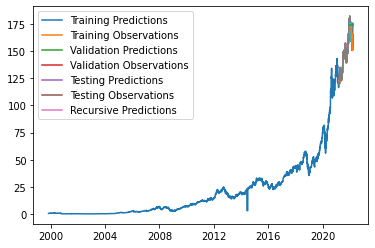

In [ ]:
import pandas as pd

"""
the main module calls all the other modules and have access to all the functions that are needed 
for building the stock model
the main three modules are:
1. get_data()- using this module for getting the last stock price and the history prices.
2. data_preparation()- using this module to prepare the data for the ML models by fixing the types of columns 
fixing the stock splits issue and more.
3. model_lstm()- predict the stock value and is the main ML model in this project.
"""

def main():
  # geting the AAPL stock data using API's
  #get_data.get_apple_stock_data()

  # clean_df = data_pre.basic_prepare(df)

  # reading the raw data that was created by the API's 
  df = pd.read_csv("/content/drive/MyDrive/Data-Mi/Project_2/DATA/AAPL_rawdata.csv")
  df_clean = data_pre.basic_prepare(df)
  df_newL = df_clean.copy()
  df_clean = df_clean.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low',
                            'close': 'Close', 'volume': 'Volume','date':'Date'})
  df_n = df_clean.copy()
  df_n = df_n.iloc[::-1]
  New_LSTM(df_n,'2021-03-25', '2022-03-21')
    #get_data.get_apple_stock_data()
    # raw_data = pd.read_csv('data/apple_daily_data')
    # prepare_data = data_preparation.basic_prepare(raw_data)
    # recursive_predictions = model_lstm.LSTM_prepare_variables(prepare_data)
    # print(recursive_predictions)
    #results = ml_classification_models.classification_models(prepare_data)
    #print(results)


if __name__ == "__main__":
  main()